# Import Data

## Import the dataset

Import the dataset if you are in colab:

In [18]:
from google.colab import files
files.upload()
!ls

Saving completeDatasetPol.csv to completeDatasetPol (1).csv
'completeDatasetPol (1).csv'   logs	  sample_data
 completeDatasetPol.csv        model.h5


Set the path to the csv file:

In [0]:
PATH_CSV = "completeDatasetPol.csv"

## Function to import data

In [0]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

RANDOM_SHUFFLE_SEED = 22

#dataset
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature','NO2','O3','PM10']

DF = pd.read_csv(PATH_CSV, header=0, delimiter=';')
DF['date'] = pd.to_datetime(DF['date'],utc=True)


def importData(nb_prev_measures_for_predict):
    print("=====IMPORT=====")

    features = DF[features_considered]
    features.index = DF['date']

    dataset_test = features.values

    def higher_value(features,i):
        return[row[i] for row in dataset_test]

    max_pressure = max(higher_value(dataset_test,1))
    max_wind_force = max(higher_value(dataset_test,3))
    max_temperature = max(higher_value(dataset_test, 5))

    #normalize
    try:
      features['NO2'] = features['NO2'].apply(lambda x: x/10)
      features['O3'] = features['O3'].apply(lambda x: x/10)
      features['PM10'] = features['PM10'].apply(lambda x: x/10)
    except:
      print("no pollutants")
    features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
    features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
    features['humidity'] = features['humidity'].apply(lambda x: x/100)
    features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

    # IQ dummy  
    dummy = pd.get_dummies(features['IQ'])
    IQDummy = pd.DataFrame(columns = range(1,11,1))
    IQDummy[dummy.columns] = dummy.fillna(0)

    iqlist = list(range(1,11,1))
    for i,r in enumerate(iqlist):
        iqlist[i] = "IQ"+str(r)
    IQDummy.columns = iqlist

    #wind_direction to categorical
    dummy = pd.get_dummies(features['wind_direction'])
    windDummy = pd.DataFrame(columns = range(0,361,10))
    windDummy[dummy.columns] = dummy.fillna(0)

    features = pd.concat([features, windDummy, IQDummy], axis=1)
    features = features.drop(columns=["wind_direction","IQ"])

    features = features.fillna(0)

    x_train = []
    y_train = []
    countRow=0

    for indexRow, rowx in features.iterrows():
        # for each day we found with a value at 12:00
        if indexRow.hour == 9 and countRow >= nb_prev_measures_for_predict:
            try:
                # indexes for x (the range is inversed as our data are from the oldest to the newest)
                batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
                # indexes for y
                batchY = [countRow+8,countRow+16,countRow+24]

                #application
                y_train.append(features.iloc[batchY][iqlist].values)
                x_train.append(features.iloc[batchX].values)
            except:
                print("To long for ",indexRow)
        countRow+=1

    #x_train,y_train = shuffle(x_train,y_train, random_state=RANDOM_SHUFFLE_SEED)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    y_train = y_train.reshape(y_train.shape[0],3,10)
    print("x_train :",x_train.shape)
    print("y_train :",y_train.shape)
    
    print("====END IMPORT====")
    return(x_train,y_train)

## Function to save the results

To save the results in a csv file:

In [49]:
!mkdir logs
!ls

mkdir: cannot create directory ‘logs’: File exists
 adc.json		       logs	      modelName.h5
'completeDatasetPol (1).csv'   modelGood.h5   sample_data
 completeDatasetPol.csv        model.h5


In [0]:
%tensorflow_version 1.x

In [0]:
# code found here: https://stackoverflow.com/questions/42355122/can-i-export-a-tensorflow-summary-to-csv
import os
import numpy as np
import pandas as pd

import tensorflow as tf

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def tabulate_events(dpath):

    final_out = {}
    for dname in os.listdir(dpath):
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        out = {}

        for tag in tags:
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
                tag_values.append(event.value)
                wall_time.append(event.wall_time)
                steps.append(event.step)

            out[tag]=pd.DataFrame(data=dict(zip(steps,np.array([tag_values,wall_time]).transpose())), columns=steps,index=['value','wall_time'])

        if len(tags)>0:      
            df= pd.concat(out.values(),keys=out.keys())

        final_out[dname] = df


    return final_out

def saveProgressCSV():
  path = "logs/"
  steps = tabulate_events(path)
  pd.concat(steps.values(),keys=steps.keys()).to_csv('all_result.csv')

In [52]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'completeDatasetPol.csv', 'modelGood.h5', 'modelName.h5', 'adc.json', 'logs', 'model.h5', 'completeDatasetPol (1).csv', 'sample_data']


# Test differents models

##Librairies:

In [0]:
from keras.optimizers import RMSprop,Adam
from keras.callbacks import TensorBoard,EarlyStopping
from time import time
from keras.models import Model
from keras.layers import LSTM, Dense, Input, GRU, BatchNormalization, Dropout, Flatten, concatenate
from keras.models import save_model
from datetime import datetime
from sklearn.model_selection import KFold
from keras.callbacks import History

## Parameters:

In [0]:
# PARAMS TO TEST

## Main script

### Data

In [55]:
x_tot,y_tot = importData(32)
x_tot,y_tot = shuffle(x_tot,y_tot, random_state=RANDOM_SHUFFLE_SEED)

trainLength = int(len(x_tot)*0.8)

x_train,x_test = x_tot[:trainLength],x_tot[trainLength:]
y_train,y_test = y_tot[:trainLength],y_tot[trainLength:]

x_train,y_train = shuffle(x_train,y_train, random_state=RANDOM_SHUFFLE_SEED)
x_test,y_test = shuffle(x_test,y_test, random_state=RANDOM_SHUFFLE_SEED)

=====IMPORT=====


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

To long for  2020-02-27 09:00:00+00:00
To long for  2020-02-28 09:00:00+00:00
To long for  2020-02-29 09:00:00+00:00
x_train : (1873, 32, 54)
y_train : (1873, 3, 10)
====END IMPORT====


### Manual script:

In [56]:

OPTI = "Adam"

# Model
input_shape = (x_train.shape[-2],x_train.shape[-1])
    
# Common part
inp = Input(input_shape,name='inputLayer')

side1 = GRU(1024,input_shape=input_shape,name='GRUchrono',dropout=0.5,return_sequences=False)(inp)

side2 = GRU(1024,input_shape=input_shape,name='GRUantechrono',dropout=0.5,return_sequences=False,go_backwards=True)(inp)

_ = concatenate([side1, side2],name="Concat",axis=1)

_ = Dense(128,name='DensecommonLayer1')(_)
_ = Dropout(0.5,name='Drop1')(_)

# 3 branches
#outD1 = GRU(128,name="GRU1",dropout=0.4)(_)
    
#outD2 = GRU(128,name="GRU2",dropout=0.4)(_)

#outD3 = GRU(128,name="GRU3",dropout=0.4)(_)

# Output of each branch
outD1 = Dense(10,name="D1", activation='softmax')(_)
outD2 = Dense(10,name="D2", activation='softmax')(_)
outD3 = Dense(10,name="D3", activation='softmax')(_)
    
# compile Model
model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])   

LOSS = "categorical_crossentropy"
METRICS = ["accuracy"]
    
model.compile(optimizer=OPTI, loss={'D1': LOSS, 'D2': LOSS, 'D3': LOSS}, 
              metrics={'D1': METRICS, 'D2': METRICS, 'D3': METRICS})
model.summary()

#train:
#hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,verbose=0)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputLayer (InputLayer)         (None, 32, 54)       0                                            
__________________________________________________________________________________________________
GRUchrono (GRU)                 (None, 1024)         3314688     inputLayer[0][0]                 
__________________________________________________________________________________________________
GRUantechrono (GRU)             (None, 1024)         3314688     inputLayer[0][0]                 
__________________________________________________________________________________________________
Concat (Concatenate)            (None, 2048)         0           GRUchrono[0][0]                  
                                                                 GRUantechrono[0][0]        

In [90]:
# params:
EPOCHS = 5
kfoldsize = 10

hist = History()

k=0
for train_index,test_index in KFold(kfoldsize).split(x_train):
    k+=1
    print("--==Fold ",k,"==--")
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,verbose=0,callbacks=[hist])
    #evaluate
    ev = model.evaluate(x=x_train, y=[y_train[:,0],y_train[:,1],y_train[:,2]])
    i=0
    for key in hist.history.keys():
      if not "val" in key:
        print(key,ev[i])
        i+=1

--==Fold  1 ==--
1498/1498 [==============================] - 2s 1ms/step
loss 0.0014403297026388008
D1_loss 0.0005166413611732423
D2_loss 0.000553109566681087
D3_loss 0.0003665869007818401
D1_accuracy 1.0
D2_accuracy 1.0
D3_accuracy 1.0
--==Fold  2 ==--
1498/1498 [==============================] - 2s 1ms/step
loss 0.0020774373794297807
D1_loss 0.0006696737254969776
D2_loss 0.0008508274331688881
D3_loss 0.0005520501872524619
D1_accuracy 1.0
D2_accuracy 1.0
D3_accuracy 1.0
--==Fold  3 ==--
1498/1498 [==============================] - 2s 1ms/step
loss 0.00690734561300216
D1_loss 0.005128545220941305
D2_loss 0.0010664841393008828
D3_loss 0.0006862626178190112
D1_accuracy 0.9993324279785156
D2_accuracy 1.0
D3_accuracy 1.0
--==Fold  4 ==--
1498/1498 [==============================] - 2s 1ms/step
loss 0.0019853121161340264
D1_loss 0.0003446673508733511
D2_loss 0.000475167267723009
D3_loss 0.0011598679702728987
D1_accuracy 1.0
D2_accuracy 1.0
D3_accuracy 1.0
--==Fold  5 ==--
1498/1498 [======

### Results

Calcul

In [91]:
# train and val
rTrain=[]
rTest=[]
rVal=[]

for metric in hist.history:
  txt = str(metric)+" "+str(hist.history[metric][0])
  if "val" in metric:
    rVal.append(txt)
  else:
    rTrain.append(txt)


# test
evalModel = model.evaluate(x=x_test,y=[y_test[:,0],y_test[:,1],y_test[:,2]])
i=0
for metric in hist.history:
  if not "val" in metric:
    rTest.append("test_"+str(metric)+" "+str(evalModel[i]))
    i+=1

result = [rTrain,rVal,rTest]
rLabel=["Training","Validation","Test"]

375/375 [==============================] - 0s 1ms/step


Display

In [92]:
for i,res in enumerate(result):
  print("--==",rLabel[i],"==--")
  for metric in res:
    print(metric)

--== Training ==--
loss 0.4430089665119784
D1_loss 0.14309862
D2_loss 0.13360797
D3_loss 0.15937743
D1_accuracy 0.9510749
D2_accuracy 0.95922905
D3_accuracy 0.94514453
--== Validation ==--
val_loss 0.003947062572564355
val_D1_loss 0.0009135170839726925
val_D2_loss 0.0010737862903624773
val_D3_loss 0.0017592614749446511
val_D1_accuracy 1.0
val_D2_accuracy 1.0
val_D3_accuracy 1.0
--== Test ==--
test_loss 4.477641746520996
test_D1_loss 1.5563058853149414
test_D2_loss 1.193458914756775
test_D3_loss 1.7496190071105957
test_D1_accuracy 0.6133333444595337
test_D2_accuracy 0.7093333601951599
test_D3_accuracy 0.5920000076293945


### Show:

In [0]:
# display:
y_pred = model.predict(x_train)
y_out = []
for i in y_pred:
    y_out.append(np.argmax(i,axis=1))
y_out = np.array(y_out)+1

y_real = []
for i in range(3):
    y_real.append([])
    
for line in range(len(y_train)):
    for day in range(3):
        y_real[day].append(np.argmax(y_train[line][day]))
y_real = np.array(y_real)+1

Prediction of the air index quality


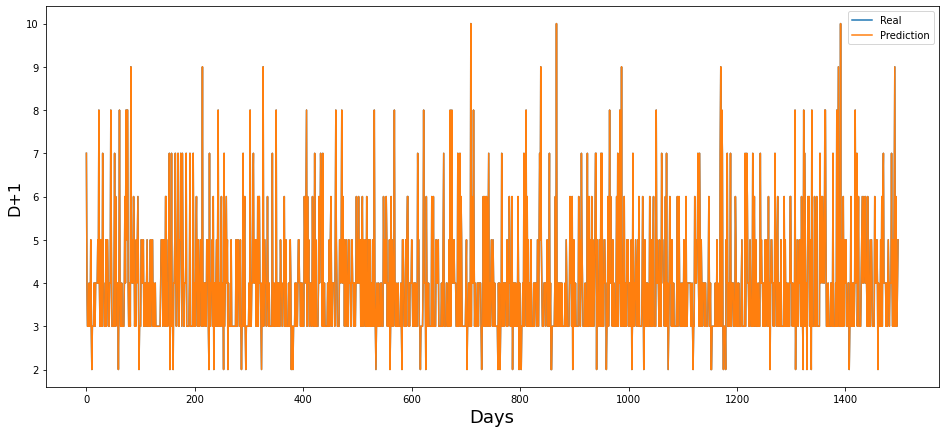

val_D1_loss 0.00109
val_D1_accuracy 1.0
D1_loss 0.20186
D1_accuracy 0.93773


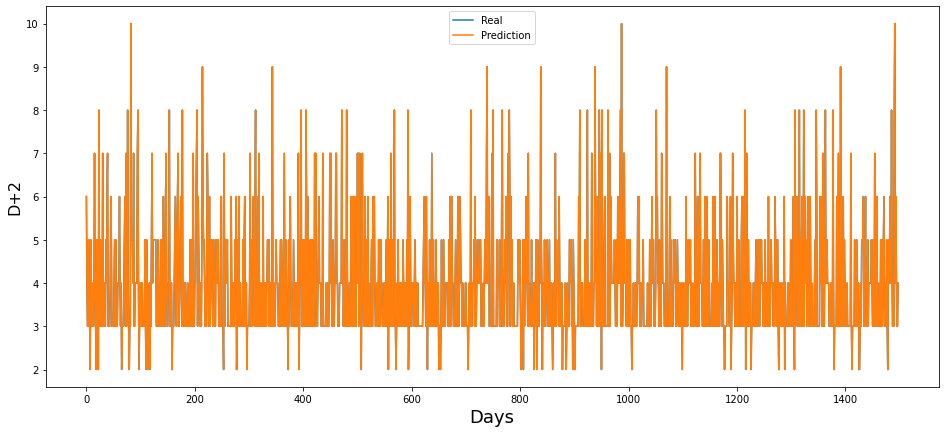

val_D2_loss 0.00163
val_D2_accuracy 1.0
D2_loss 0.14477
D2_accuracy 0.95552


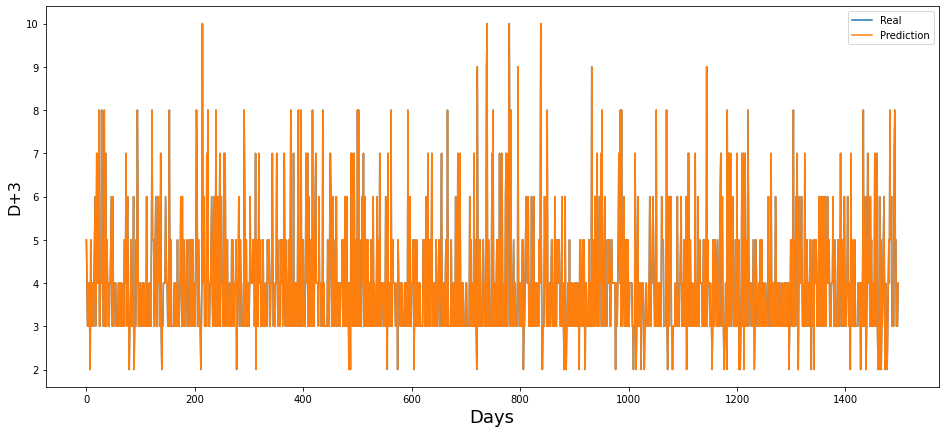

val_D3_loss 0.00215
val_D3_accuracy 1.0
D3_loss 0.16722
D3_accuracy 0.94514


In [85]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16,7)

print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_real[plusDay], label='Real')
    plt.plot(y_out[plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))

In [0]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
for i in range(1,4):
  # summarize history for accuracy D1
  plt.plot(hist.history[f'D{i}_accuracy'])
  plt.plot(hist.history[f'val_D{i}_accuracy'])
  plt.title('model accuracy')
  plt.ylabel(f'accuracy D{i}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

### export model

In [0]:
from google.colab import files

In [93]:
modelName = "model5.h5"
model.save(modelName)
!ls
files.download(modelName)

 adc.json		       logs	   model4.h5	  model.h5
'completeDatasetPol (1).csv'   model2.h5   model5.h5	  modelName.h5
 completeDatasetPol.csv        model3.h5   modelGood.h5   sample_data


In [0]:
"""!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})"""